In [210]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [211]:
with open("names.txt",'r') as f:
    words = f.read().split('\n')

In [212]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [213]:
max([len(w) for w in words])

15

In [214]:
# modifying 
# . : end of seq
# ~ : start of seq
# padding with . to make all words of same length
max_len = 16            # 15+1
words_mod = ['~' + word.lower() + '.'*(max_len-len(word)) for word in words]

In [215]:
words_mod[:5]

['~emma............',
 '~olivia..........',
 '~ava.............',
 '~isabella........',
 '~sophia..........']

In [216]:
stoi = {chr(c):(c-97) for c in range(97,122+1)}
stoi['.'] = 26
stoi['~'] = 27
itos = {stoi[k]:k for k in stoi.keys()}

In [217]:
def encoder(l):
    ''' It will take a list of strings (words) and it will return a 2D list of each char encoded '''
    res = [list(el) for el in l]   # splitting it characterwise
    for i,el in enumerate(res):
        for j,ch in enumerate(el):
            res[i][j] = stoi[ch]
    
    return res


def decoder(l):
    ''' It will take a 2D list of int and decode it to a 1D list of strings '''
    res = []
    for el in l:
        w = ''.join(itos[ch] for ch in el)
        res.append(w)
    
    return res

In [218]:
data = encoder(words_mod)

n = 0.9

# shuffling data
np.random.shuffle(data)

ul = int(n*len(data))

data_train = data[:ul]
data_val = data[ul:]

len(data_train), len(data_val)

(28829, 3204)

In [219]:
data_val[:3]

[[27, 8, 19, 25, 0, 24, 0, 13, 13, 0, 26, 26, 26, 26, 26, 26, 26],
 [27, 3, 0, 24, 18, 4, 13, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26],
 [27, 9, 20, 11, 8, 4, 19, 7, 26, 26, 26, 26, 26, 26, 26, 26, 26]]

In [220]:
# buidling the dataset
X_train = torch.tensor([el[:max_len] for el in data_train])
X_test = torch.tensor([el[:max_len] for el in data_val])
Y_train = torch.tensor([el[1:max_len + 1] for el in data_train])
Y_test = torch.tensor([el[1:max_len + 1] for el in data_val])

In [221]:
X_train[:3]

tensor([[27, 18,  7,  0, 11,  8, 24,  0,  7, 26, 26, 26, 26, 26, 26, 26],
        [27,  4, 11, 11,  8, 24,  0,  7, 26, 26, 26, 26, 26, 26, 26, 26],
        [27,  5,  4, 17, 17,  8, 18, 26, 26, 26, 26, 26, 26, 26, 26, 26]])

In [222]:
Y_train[:3]

tensor([[18,  7,  0, 11,  8, 24,  0,  7, 26, 26, 26, 26, 26, 26, 26, 26],
        [ 4, 11, 11,  8, 24,  0,  7, 26, 26, 26, 26, 26, 26, 26, 26, 26],
        [ 5,  4, 17, 17,  8, 18, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]])

In [223]:
n_layers = 3
n_hidden = 128
n_output = 27
alpha = 1e-3
n_vocab = 28
n_emb = 128
batch_size = 640
max_len = 16

In [232]:
class LSTM_OP(nn.Module):

    def __init__(self, n_vocab, n_emb, n_hidden, n_layers, dropout=0.1):
        super().__init__()
        self.n_emb = n_emb
        self.n_vocab = n_vocab
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.embedding = nn.Embedding(n_vocab, n_emb)
        self.lstm = nn.LSTM(n_emb, n_hidden, n_layers, batch_first=True, dropout=dropout)
        # batch_first=True means that the first dimension of the input tensor will be the batch size -> (batch_size, seq_len, n_features)
        self.fc = nn.Linear(n_hidden, n_emb)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n_emb, n_vocab)
    
    def forward(self,x):
        '''x: (batch_size, seq_len)'''
        # pack_padded_seq can be applied to reduce computation but not necessary here
        x = self.embedding(x)                                           # (batch_size, seq_len, n_emb)
        cell_state = torch.zeros(self.n_layers, x.size(0), self.n_hidden)       # long term memory
        hidden_state = torch.zeros(self.n_layers, x.size(0), self.n_hidden)     # short term memory
        out, _ = self.lstm(x, (hidden_state, cell_state))       # we just need the long term memory
        # Since we're often interested in predicting based on the entire sequence, taking the last output represents the accumulated information over the whole sequence.
        out = self.fc(out)
        out = self.relu(out)
        out = self.output(out)

        return out
    
    def generate_words(self,X,max_len):
        
        self.eval()
        t = X.shape[1] 
            
        for i in range(max_len - t + 1):      # t:max -> 17
            out = self.forward(X)
            out = out[:,-1,:]      #(B,C)   we just need the last char
            probs = F.softmax(out,dim=-1)
            # return indices
            next_char = torch.multinomial(probs,num_samples=1)   #(B,1)
            X = torch.cat((X,next_char),dim=1)

        return X

In [275]:
model = LSTM_OP(n_vocab, n_emb, n_hidden, n_layers, dropout=0.2)

In [276]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=alpha)
model.train()

LSTM_OP(
  (embedding): Embedding(28, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=128, out_features=28, bias=True)
)

In [277]:
@torch.no_grad()
def get_loss():
    '''Returns the loss on the validation set'''
    out = model(X_test)
    loss = criterion(out.view(-1,n_vocab),Y_test.view(-1))
    return loss.item()

In [278]:
get_loss()

3.2924938201904297

In [279]:
J_hist = []

In [280]:
epochs = 30
for epoch in range(epochs):
    for i in range(X_train.shape[0]//batch_size):
        X = X_train[i*batch_size:(i+1)*batch_size]
        y = Y_train[i*batch_size:(i+1)*batch_size]             # (batch_size, seq_len)
        model.train()
        optimizer.zero_grad()
        out = model(X)         # (batch_size, seq_len, n_vocab)
        # flatten the output and target
        out = out.view(-1, n_vocab)          # (batch_size*seq_len, n_vocab)
        y = y.view(-1)                       # (batch_size*seq_len)
        loss = criterion(out, y)
        J_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        if i%10 == 0:
            print(f'Epoch: {epoch+1} - Iteration: {i+1} Loss: {loss.item()}')
        
    print(f'Epoch: {epoch+1} Validation Loss: {get_loss()}')

Epoch: 1 - Iteration: 1 Loss: 3.292637348175049
Epoch: 1 - Iteration: 11 Loss: 1.758795976638794
Epoch: 1 - Iteration: 21 Loss: 1.4291845560073853
Epoch: 1 - Iteration: 31 Loss: 1.3465253114700317
Epoch: 1 - Iteration: 41 Loss: 1.3251841068267822
Epoch: 1 Validation Loss: 1.2886110544204712
Epoch: 2 - Iteration: 1 Loss: 1.3191988468170166
Epoch: 2 - Iteration: 11 Loss: 1.2461971044540405
Epoch: 2 - Iteration: 21 Loss: 1.2224266529083252
Epoch: 2 - Iteration: 31 Loss: 1.1876757144927979
Epoch: 2 - Iteration: 41 Loss: 1.1936991214752197
Epoch: 2 Validation Loss: 1.1767185926437378
Epoch: 3 - Iteration: 1 Loss: 1.207777738571167
Epoch: 3 - Iteration: 11 Loss: 1.1589257717132568
Epoch: 3 - Iteration: 21 Loss: 1.1573731899261475
Epoch: 3 - Iteration: 31 Loss: 1.1417443752288818
Epoch: 3 - Iteration: 41 Loss: 1.1597363948822021
Epoch: 3 Validation Loss: 1.1460222005844116
Epoch: 4 - Iteration: 1 Loss: 1.1736698150634766
Epoch: 4 - Iteration: 11 Loss: 1.1279008388519287
Epoch: 4 - Iteration: 

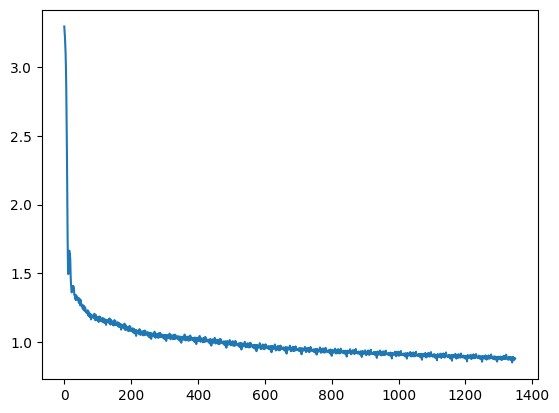

In [281]:
import matplotlib.pyplot as plt
plt.plot(J_hist)

In [282]:
get_loss()

0.9079971313476562

In [283]:
# let's generate some words
n = 25
x = torch.tensor(25*[[27]])
words = model.generate_words(x, max_len)
words = decoder(words.tolist())

In [284]:
words = [w[1:w.find('.')] for w in words]

In [285]:
words

['samera',
 'daylene',
 'onica',
 'taysen',
 'keniah',
 'bahdred',
 'ashu',
 'lidap',
 'plete',
 'jamonda',
 'anya',
 'ota',
 'mauden',
 'nezricha',
 'colat',
 'jidia',
 'roway',
 'amariella',
 'keven',
 'zian',
 'tasalen',
 'ebetkay',
 'catyoni',
 'radu',
 'testam']

In [286]:
# saving the model
torch.save(model.state_dict(),'lstm_model.pth')

In [287]:
# generating samples
n = 250
x = torch.tensor(n*[[27]])
words = model.generate_words(x, max_len)
words = decoder(words.tolist())
words = [w[1:w.find('.')] for w in words]

with open ('lstm_samples.txt','w') as f:
    for w in words:
        f.write(w + '\n')

### Yayyy!!!!!!!!!